# vqgan-jax encoding tests

Notebook based on [vqgan-jax-reconstruction](https://colab.research.google.com/drive/1mdXXsMbV6K_LTvCh3IImRsFIWcKU5m1w?usp=sharing) by @surajpatil.

In [1]:
import io

import requests
from PIL import Image
import numpy as np

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

In [2]:
from torchvision.transforms import InterpolationMode

The following assumes [vqgan-jax](https://github.com/patil-suraj/vqgan-jax.git) has been checked out in a subdirectory where this notebook is located. Adjust accordingly, if necessary.

In [3]:
%cd vqgan-jax

/home/pedro/vqgan-jax/vqgan-jax


## Reconstruction

In [4]:
from modeling_flax_vqgan import VQModel

In [5]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content))

def custom_to_pil(x):
    x = np.clip(x, 0., 1.)
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def preprocess(img, target_image_size=256,):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=InterpolationMode.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1).numpy()

In [6]:
model = VQModel.from_pretrained("valhalla/vqgan-imagenet-f16-1024")

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: TPU Host Interpreter


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [7]:
url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'
size = 384
image = download_image(url)
image = preprocess(image, size)

In [8]:
quant_states, indices = model.encode(image)

In [9]:
quant_states.shape

(1, 24, 24, 256)

In [10]:
indices.shape

(1, 576)

In [11]:
rec_quant = model.decode(quant_states)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [12]:
rec_indices = model.decode_code(indices)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [13]:
rec_quant.shape, rec_indices.shape

((1, 384, 384, 3), (1, 384, 384, 3))

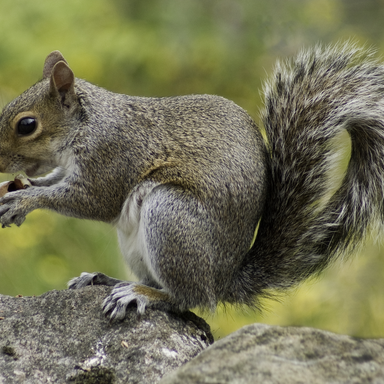

In [15]:
custom_to_pil(image[0])

Reconstructed using the quantized states:

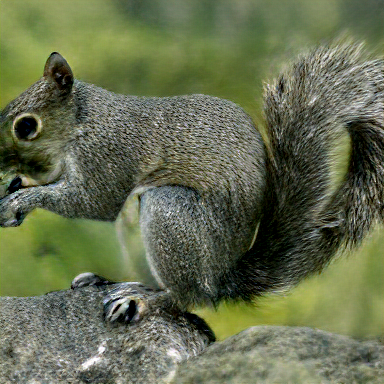

In [16]:
custom_to_pil(np.asarray(rec_quant[0]))

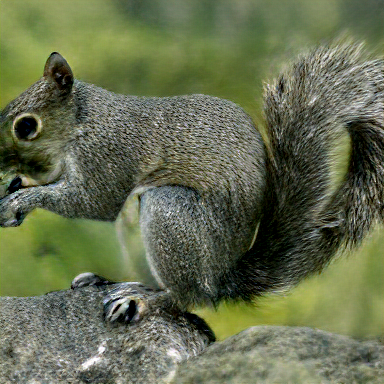

In [17]:
custom_to_pil(np.asarray(rec_indices[0]))

The shapes of the quantized states and the indices are larger for larger images. We'll store `indices` because that's what they need for our `seq2seq` model. And they are smaller.

## Encoding function

In [18]:
def encode(model, batch):
    _, indices = model.encode(batch)
    return indices

In [19]:
import jax
from jax import random

In [20]:
random_images = random.normal(random.PRNGKey(1), (10, 256, 256, 3))

In [21]:
random_images.shape

(10, 256, 256, 3)

In [22]:
result_batch = encode(model, random_images)

In [23]:
result_batch.shape

(10, 256)

Encoding this way is slow, we'll need to use `jit` at some point. `pmap`, which we'll use later, already jits the target function.

----

**Note that decoding does not seem to support non-square images**. The following produces an error when decoding.

In [24]:
# non_square_image = random.normal(random.PRNGKey(1), (1, 256, 512, 3))
# encoded = encode(model, non_square_image)
# decoded = model.decode_code(encoded)

## Simple Dataset

When we need to load both captions and images, we can use Luke Melas-Kyriazi's `dataset.py` which he created for this purpose. For now, we'll just test a simple dataset consisting of just images.

In [97]:
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader

class ImageDataset(Dataset):
    def __init__(self, image_list_path: str, image_size: int, max_items=None):
        """
        :param image_list_path: Path to a file containing a list of all images. We assume absolute paths for now.
        :param image_size: Image size. Source images will be resized and center-cropped.
        :max_items: Limit dataset size for debugging
        """
        self.image_list = pd.read_csv(image_list_path, sep='\t', header=None)
        if max_items is not None: self.image_list = self.image_list[:max_items]
        self.image_size = image_size
        
    def __len__(self):
        return len(self.image_list)
    
    def _get_raw_image(self, i):
        image_path = Path(self.image_list.iloc[i][0])
        return default_loader(image_path)
    
    # TODO: we could maybe use jax resizing / scaling functions
    def resize_image(self, image):
        s = min(image.size)
        r = self.image_size / s
        s = (round(r * image.size[1]), round(r * image.size[0]))
        image = TF.resize(image, s, interpolation=InterpolationMode.LANCZOS)
        image = TF.center_crop(image, output_size = 2 * [self.image_size])
        image = torch.unsqueeze(T.ToTensor()(image), 0)
        image = image.permute(0, 2, 3, 1).numpy()
        return image
    
    def __getitem__(self, i):
        image = self._get_raw_image(i)
        image = self.resize_image(image)
        return image

We'll use a tiny dataset to test.

In [98]:
image_list = '/data/CC12M/10k-train.txt'

In [103]:
dataset = ImageDataset(image_list, image_size=256, max_items=128)

In [104]:
len(dataset)

128

In [105]:
dataset[0]

array([[[[0.7254902 , 0.7058824 , 0.68235296],
         [0.7254902 , 0.7058824 , 0.68235296],
         [0.7254902 , 0.7058824 , 0.68235296],
         ...,
         [0.7411765 , 0.7254902 , 0.6784314 ],
         [0.7411765 , 0.7254902 , 0.6784314 ],
         [0.7372549 , 0.72156864, 0.6745098 ]],

        [[0.7294118 , 0.70980394, 0.6862745 ],
         [0.7294118 , 0.70980394, 0.6862745 ],
         [0.7294118 , 0.70980394, 0.6862745 ],
         ...,
         [0.74509805, 0.7294118 , 0.68235296],
         [0.7411765 , 0.7254902 , 0.6784314 ],
         [0.7372549 , 0.72156864, 0.6745098 ]],

        [[0.7372549 , 0.7176471 , 0.69411767],
         [0.7372549 , 0.7176471 , 0.69411767],
         [0.7372549 , 0.7176471 , 0.69411767],
         ...,
         [0.7490196 , 0.73333335, 0.6862745 ],
         [0.74509805, 0.7294118 , 0.68235296],
         [0.74509805, 0.7294118 , 0.68235296]],

        ...,

        [[0.80784315, 0.76862746, 0.75686276],
         [0.80784315, 0.77254903, 0.75686276]

In [54]:
dataset[0].shape

(1, 256, 256, 3)

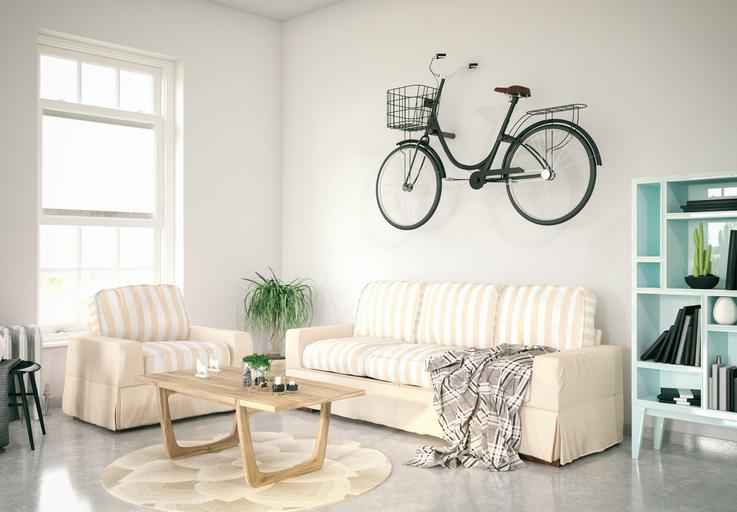

In [55]:
dataset._get_raw_image(0)

In [56]:
dataset._get_raw_image(0).size

(737, 512)

In [57]:
from torch.utils.data import DataLoader

In [59]:
batch_size = 32
num_workers = 64

In [78]:
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

### Inference

Let's iterate first. This will use just one TPU, and the code is not jitted.

In [79]:
from tqdm import tqdm

In [110]:
results = None
for batch in tqdm(dataloader):
    # [32, 1, 256, 256, 3] -> [32, 256, 256, 3]
    batch = batch.squeeze(1)
    encoded = np.asarray(encode(model, batch))
    results = np.concatenate((results, encoded), axis=0) if results is not None else encoded

100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.18s/it]


In [111]:
results.shape

(128, 256)

We'll now create super-batches for the TPUs, by getting 8 batches from the dataloader. An alternative would be to multiply the batch_size by 8 and then split them.

In [130]:
def superbatch_generator(dataloader):
    iter_loader = iter(dataloader)
    for batch in iter_loader:
        superbatch = [batch.squeeze(1)]
        try:
            for b in range(7):
                batch = next(iter_loader)
                if batch is None:
                    break
                # Skip incomplete last batch
                if batch.shape[0] == dataloader.batch_size:
                    superbatch.append(batch.squeeze(1))
        except StopIteration:
            pass
        superbatch = torch.stack(superbatch, axis=0)
        yield superbatch

Use irregular number of items to see if the generator works correctly.

In [132]:
dataset = ImageDataset(image_list, image_size=256, max_items=400)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

In [133]:
superbatches = superbatch_generator(dataloader)

In [135]:
for superbatch in superbatches:
    print(superbatch.shape)

torch.Size([8, 32, 256, 256, 3])
torch.Size([4, 32, 256, 256, 3])


Looks good. Let's try to use `pmap`

## `pmap`

In [155]:
superbatches = superbatch_generator(dataloader)

In [156]:
from jax import pmap

In [157]:
for superbatch in superbatches:
    encoded = pmap(lambda batch: encode(model, batch))(superbatch.numpy())
    print(encoded.shape)

(8, 32, 256)
(4, 32, 256)


It works! Let's wrap it and run the whole process on the 10k images subset.

## 10k encoding

We'll encode the train set of the small 10k subset we prepared. The train set contains 7926 images.

In [195]:
def encode_dataset(dataset, batch_size=32):
    num_workers = 16
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    superbatches = superbatch_generator(dataloader)
    
    # TODO: save to disk as we go, do not accumulate everything in RAM
#     encoder = pmap(lambda batch: encode(model, batch))
    results = None
    for superbatch in tqdm(superbatches):
        encoded = pmap(lambda batch: encode(model, batch))(superbatch.numpy())
        encoded = encoded.reshape(encoded.shape[0] * encoded.shape[1], -1)
        results = np.concatenate((results, encoded), axis=0) if results is not None else encoded
    return results

In [199]:
dataset = ImageDataset(image_list, image_size=256)
encoded_dataset = encode_dataset(dataset, batch_size=64)

16it [03:38, 13.64s/it]


In [200]:
encoded_dataset.shape

(7872, 256)

In [201]:
len(dataset)

7926

(We are skipping the last incomplete batch).

## ToDo

* Process the last incomplete batch.
* Performance tuning. This feels slow.
  - Can we load data differently?
  - Can we prevent transferring to CPU after each iteration?
* Save results to disk, possibly as we go. This will be necessary to handle large datasets.